In [2]:
%load_ext autoreload
%autoreload 2

# TODO: Think about plotting subset sizes against predicted probability? (confidence)

DATASET_NAME = "toxigen"
LABEL_SPACE = ["non-toxic", "toxic"]
MODEL_NAME = "deberta-large"
SEED = 42
POOLER = "mean_with_attention"
LAYER = 24

In [3]:
# load embeddings
from data.embeddings import load_saved_embeddings
import numpy as np
train_embeddings = load_saved_embeddings(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    split="train",
    pooler=POOLER,
    layer=LAYER
)

eval_embeddings = load_saved_embeddings(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    split="eval",
    pooler=POOLER,
    layer=LAYER
)

test_embeddings = load_saved_embeddings(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    split="test",
    pooler=POOLER,
    layer=LAYER
)

train_eval_embeddings = np.vstack([train_embeddings, eval_embeddings])


# load classifier
from data.models import load_saved_wrapperbox_model
knn_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="KNN"
)

svm_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="SVM",
)

dt_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="DecisionTree",
)

lmeans_clf = load_saved_wrapperbox_model(
    dataset=DATASET_NAME,
    model=MODEL_NAME,
    seed=SEED,
    pooler=POOLER,
    wrapperbox="LMeans",
)

# load labels 
from data.datasets import load_dataset_from_hf, load_labels_at_split
import numpy as np
dataset = load_dataset_from_hf(dataset=DATASET_NAME)
train_labels = load_labels_at_split(dataset, "train")
eval_labels = load_labels_at_split(dataset, "eval")
train_eval_labels = np.concatenate([train_labels, eval_labels])
test_labels = load_labels_at_split(dataset, "test")

from datasets import DatasetDict, concatenate_datasets
train_eval_dataset = concatenate_datasets([dataset["train"], dataset["eval"]])
dataset_dict = DatasetDict(
    {"train": train_eval_dataset, "test": dataset["test"]}
)

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/samsoup/.cache/huggingface/token
Login successful


In [4]:
from typing import Iterable
import matplotlib.pyplot as plt
# plt.style.use('ggplot') # change this to others by checking plt.style.available

def plot_histogram(
    dataset_name: str,
    algo_name: str,
    num_examples_per_subset: Iterable[int], 
    test_labels: Iterable[int], 
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10,6),
):
    plt.figure(figsize=figsize)
    n, bins, edges = plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black',
        alpha=0.7
    )
    # plt.gca().set_facecolor('white') # white background
    plt.grid(color="gray", linestyle="-", linewidth=0.25, alpha=0.5)
    if len(bins) > tick_threshold:
        # too much bins, only show a percentage of ticks
        n = int(1 / tick_percentage_to_show)
    else:
        n = 1
    plt.xticks(bins[::n], rotation="vertical")
    # tick_locs = np.arange(0, max(num_examples_per_subset), tick_inc)
    # plt.xticks(tick_locs, rotation='vertical')
    # plt.xticks(bin_edges, rotation="vertical")
    plt.xlim(left=0) # adjust for bar width
    # plt.subplots_adjust(right=0.9)  # Eliminate extra right white space
    plt.xlabel('Size of Minimal Set')
    plt.ylabel('Frequency')
    plt.title(
        f'Histogram of Size of Minimal Sets for {dataset_name.capitalize()}, {algo_name}'
    )
    plt.text(
        max(num_examples_per_subset), 
        max(plt.hist(
            num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
        )[0]), 
        f'{len(num_examples_per_subset)}/{len(test_labels)}', 
        horizontalalignment='right', verticalalignment='top'
    )
    # Calculate the median and plot as a line
    median_value = np.median(num_examples_per_subset)
    plt.axvline(
        median_value, color='red', linestyle='--', linewidth=2, label='Median'
    )
    # Label the median line with a piece of text
    text_height = max(plt.hist(
        num_examples_per_subset, bins=bins, color='skyblue', edgecolor='black'
    )[0]) * 0.8
    plt.text(
        median_value * 1.05, text_height, f'Median: {median_value}', color='red', 
        fontsize=12
    )
    # Darken the axis lines
    # plt.gca().spines['bottom'].set_color('black')
    # plt.gca().spines['left'].set_color('black')
    plt.tight_layout()
    plt.show()

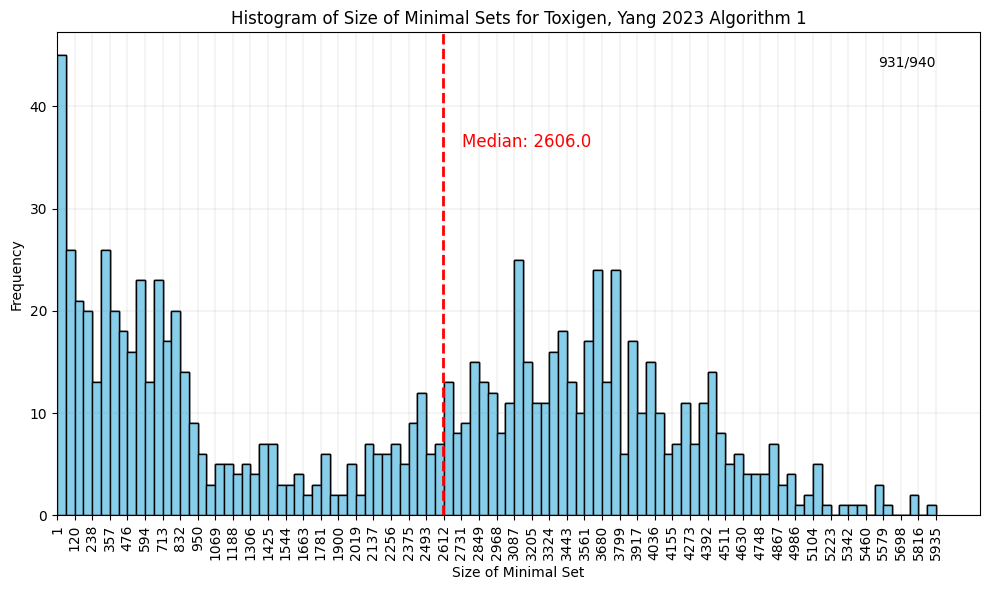

In [39]:
## Visualize Yang 2023 Algorithm1 
import pickle

with open (f"yang2023_alg1_toxigen500.pickle", 'rb') as handle:
    flip_list = pickle.load(handle)

num_examples = []
# compute some basic statistics
for i, l in enumerate(flip_list):
    if l is None:
        continue
    # compute the length of indices
    num_examples.append(len(l))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="Yang 2023 Algorithm 1",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

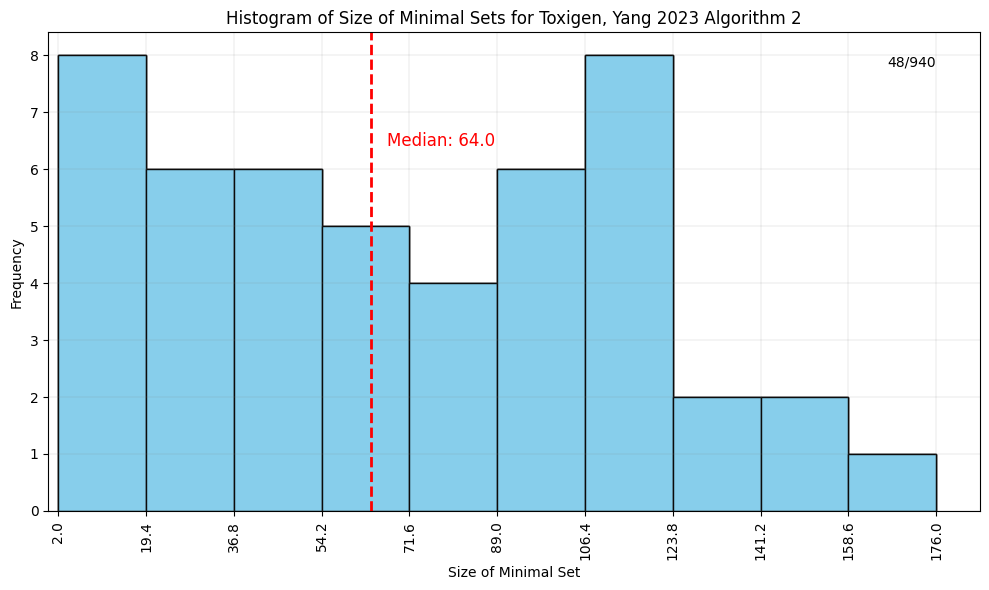

In [41]:
import pickle

# from utils.constants import RESULTS_DIR

# output_dir = RESULTS_DIR / "MinimalSubset"

with open (f"yang2023_alg2_toxigen500.pickle", 'rb') as handle:
    flip_list = pickle.load(handle)

num_examples = []
# compute some basic statistics
for i, l in enumerate(flip_list):
    if l is None or len(l) == 0:
        continue
    # compute the length of indices
    num_examples.append(len(l))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="Yang 2023 Algorithm 2",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=10,
    tick_threshold=100,
    tick_percentage_to_show=1.0,
    figsize=(10, 6)
)

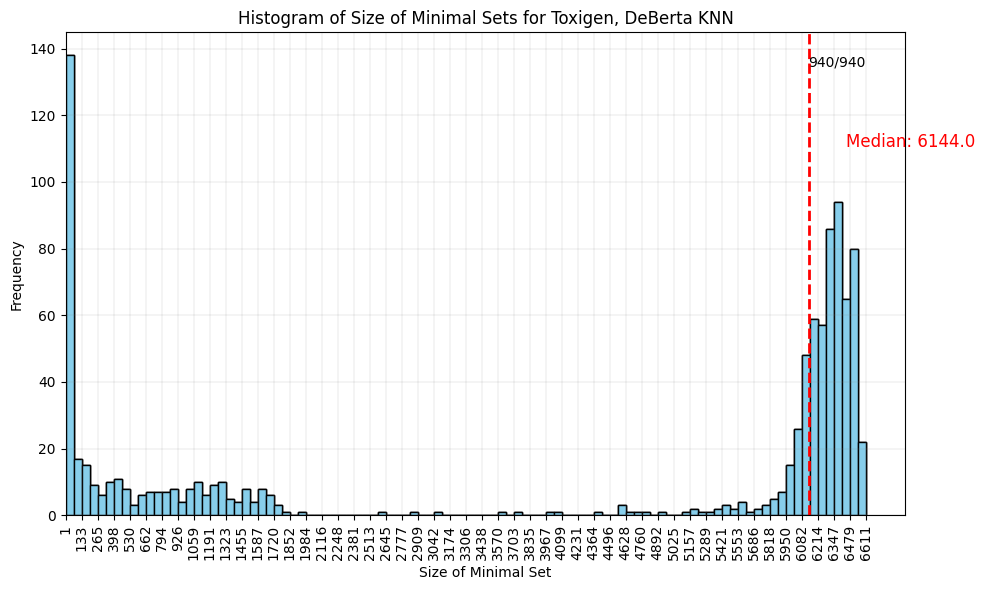

In [61]:
## Visualize KNN
from utils.io import load_json

data = load_json("toxigen_deberta_large_KNN_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta KNN",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=100,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

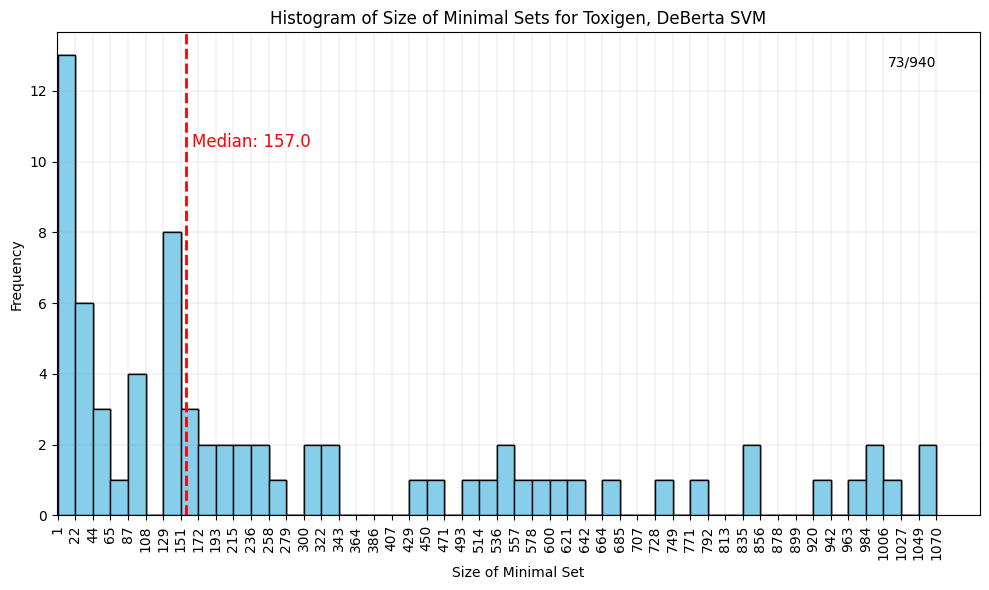

In [66]:
## Visualize SVM
from utils.io import load_json

data = load_json("toxigen_deberta_large_SVM_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta SVM",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

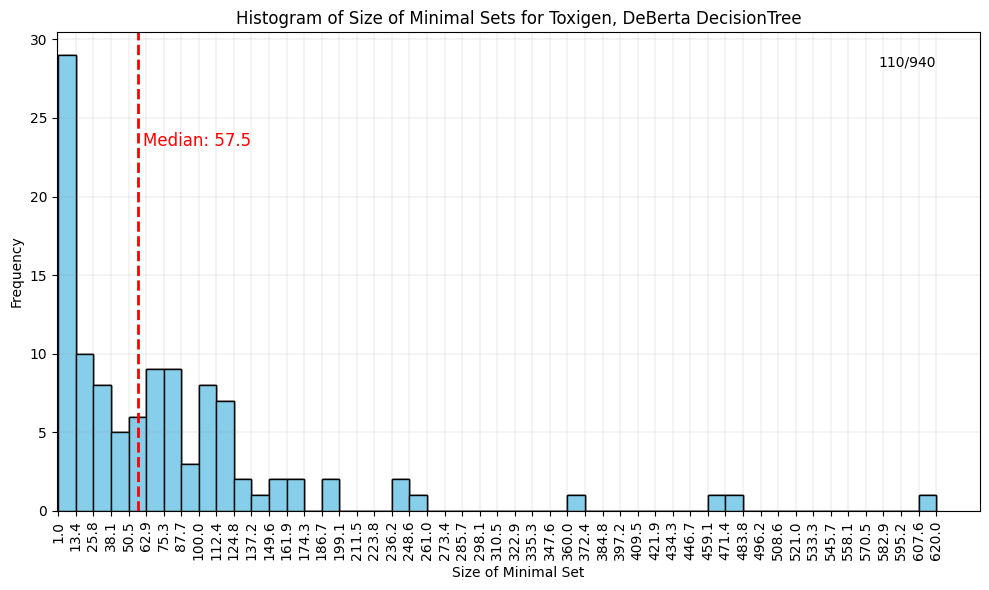

In [6]:
## Visualize DT
from utils.io import load_json

data = load_json("toxigen_deberta_large_DecisionTree_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

plot_histogram(
    dataset_name=DATASET_NAME,
    algo_name="DeBerta DecisionTree",
    num_examples_per_subset=num_examples,
    test_labels=test_labels,
    bins=50,
    tick_threshold=100,
    tick_percentage_to_show=0.5,
    figsize=(10, 6)
)

Unique values: [1957, 2008, 2054, 2057, 2064, 2078, 2083, 2120, 2143, 2144, 2163, 2184, 2191, 6414]
Counts: [  1  63   2   1   1   1   1   5   1   1   2   2 196 663]
+--------------------------------------+----------+
|   LMeans Unique Minimal Subset Sizes |   Counts |
|--------------------------------------+----------|
|                                 1957 |        1 |
|                                 2008 |       63 |
|                                 2054 |        2 |
|                                 2057 |        1 |
|                                 2064 |        1 |
|                                 2078 |        1 |
|                                 2083 |        1 |
|                                 2120 |        5 |
|                                 2143 |        1 |
|                                 2144 |        1 |
|                                 2163 |        2 |
|                                 2184 |        2 |
|                                 2191 |      196 |
| 

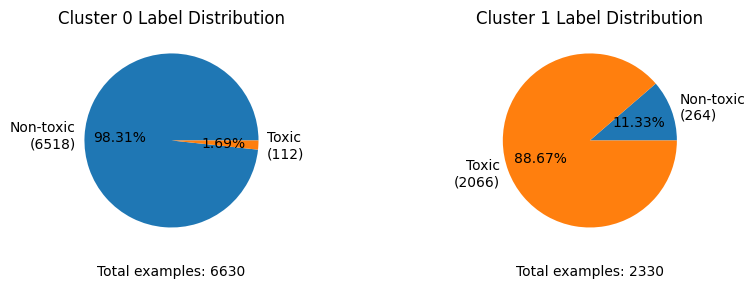

In [138]:
## Visualize LMeans
from tabulate import tabulate
from utils.io import load_json
from typing import Counter
import numpy as np
import pandas as pd

data = load_json("toxigen_deberta_large_LMeans_minimal_subsets.json")

num_examples = []
for d in data:
    if d['minimum_subset']:
        num_examples.append(len(d['minimum_subset']))

# LMeans is a bit special: looks like we only have ~15 unique 
# subset values, so instead show frequency of thse values
unique_values, counts = np.unique(num_examples, return_counts=True)
print("Unique values:", unique_values.tolist())
print("Counts:", counts)

df = pd.DataFrame({'LMeans Unique Minimal Subset Sizes': unique_values, 'Counts': counts})

print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

# Show Cluster Distribution
from utils.partition import get_partition_X
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, lmeans_clf.kmeans_.n_clusters, figsize=(9, 3))
n_clusters = lmeans_clf.kmeans_.n_clusters
for cluster_id, ax in zip(range(n_clusters), axs):
    _, train_indices = get_partition_X(lmeans_clf.kmeans_.labels_, cluster_id)
    cluster_labels = train_eval_labels[train_indices]
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)
    
    # For plotting cluster distribution
    percents = [counts / np.sum(label_counts) for counts in label_counts ]
    labels = [
        f'{label.capitalize()}\n({count})'
        for label, p, count in zip(LABEL_SPACE, percents, label_counts)
    ]
    ax.pie(label_counts, labels = labels, autopct='%1.2f%%')
    ax.set_title(f'Cluster {cluster_id} Label Distribution')
    ax.text(
        0.5, -0.1, f'Total examples: {np.sum(label_counts)}', 
        horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes
    )
plt.tight_layout()
plt.show()

In [94]:
lmeans_clf.kmeans_.labels_.shape[0]

8960

In [92]:
lmeans_clf.kmeans_.n_clusters

2